In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import traceback
import sqlalchemy as sqla
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Function that performs one iteration of gradient descent to improve the model parameters:
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
select = df[['PL','DE']]

select_2012 = select.loc['2012-01-01':'2015-12-31']


nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
print(nonan)

nonan = nonan / nonan.max(axis=0)

x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['PL'].values,test_size=0.2)

In [2]:
#df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
#select = df[['PL','DE']]

#select_2012 = select.loc['2012-01-01':'2015-12-31']

df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
gdp = pd.read_csv('gdp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
pop = pd.read_csv('population_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
tmp =  pd.read_csv('tmp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])

joined = df.join(gdp, on='DateTime', how='left', lsuffix = '', rsuffix = '_GDP', sort=False)

print(df.shape)
print(gdp.shape)

(87648, 40)
(10, 34)


In [3]:
joined = joined.join(pop, on='DateTime', how='left', lsuffix = '', rsuffix = '_POP', sort=False)
joined = joined.join(tmp, on='DateTime', how='left', lsuffix = '', rsuffix = '_TMP', sort=False)
joined = joined.replace(',','', regex=True)
joined_interpolate = joined.interpolate(method='ffill') # or method='index' works too
#pl = joined[['PL','PL_GDP','PL_POP', 'PL_TMP']]



In [4]:
from copy import deepcopy
#country_datasets = pd.DataFrame
country_datasets = []
datasets = []
country_list = ['PL', 'DE']

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])

for each in country_datasets:
    name = each[0]
    dataset = each[1]
    #datasets.append([deepcopy(dataset), deepcopy(datasets)])

In [5]:
from sklearn.preprocessing import MinMaxScaler

#nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

#for sub_df in joined:
#    nonan = sub_df.dropna(how='all')

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works

x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.795)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()

In [29]:
# TEST
import torch.nn.functional as F

In [30]:
# TEST

country_datasets = []
datasets = []
country_list = ['PL', 'DE']

#for country in country_list:
#    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
#    country_datasets.append([country, country_dataset])
#    print(country)

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    #country_datasets.concat([country_datasets,country_dataset])
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])
    #b = pd.concat([country_datasets, country_dataset])
    #se = pd.Series(country_dataset.all())
    #b = country_datasets.concat([country_dataset,se])
    #country_datasets['new_col'] = country_dataset
    #print(country)

#print(b)
#print(country_datasets[1])

i = 0
for each in country_datasets:
    #print(each)
    #print("each")
    name = each[0]
    #print(name)
#    a = each[1]
    #dataset.append(a)
    dataset = each[1]
    datasets.append([deepcopy(dataset), deepcopy(datasets)])

nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works

x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.2)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()


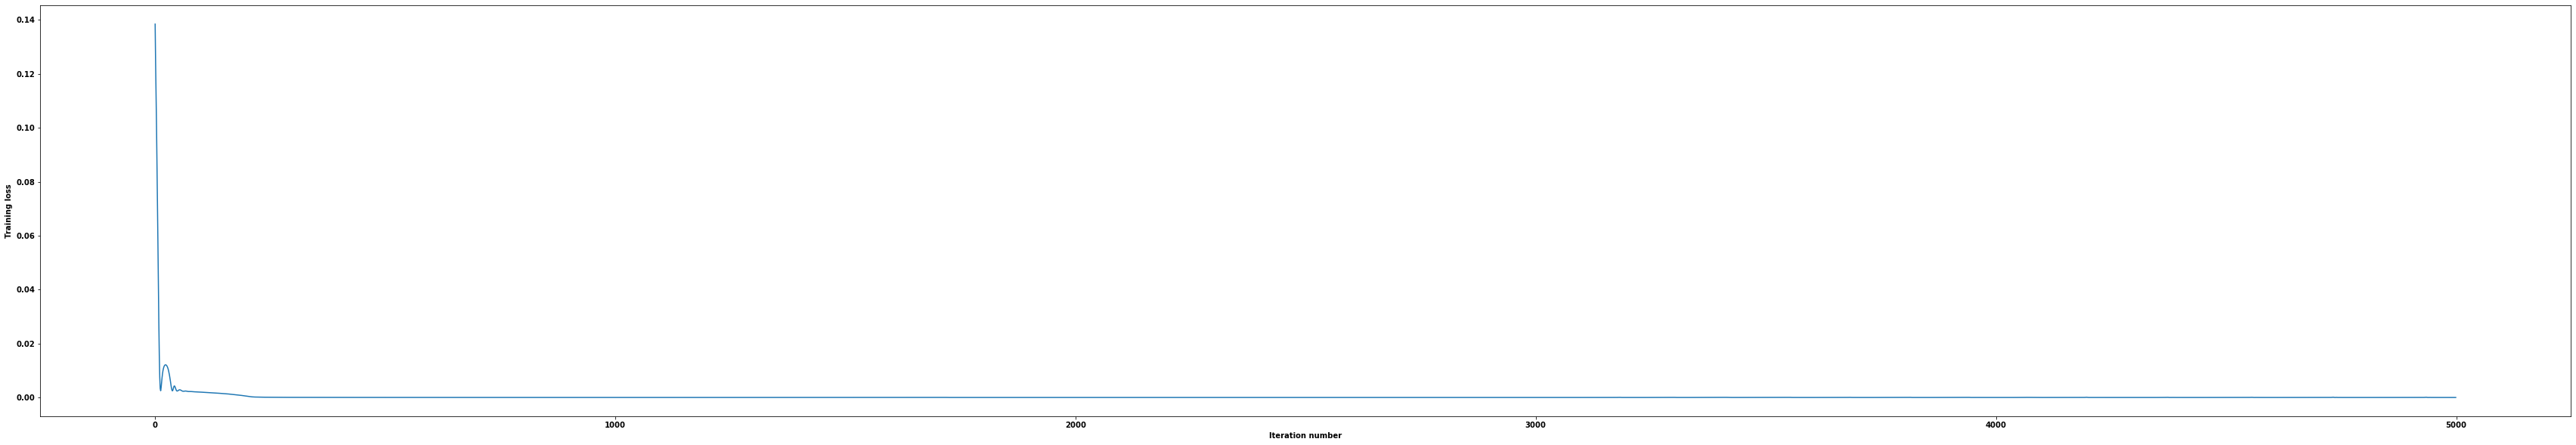

In [31]:
n_pmu = X_train_torchDE.shape[1]

# Neural network class:
class fault_net(nn.Module): 
    def __init__(self,n_hidden): # Passing the parameter n_hidden to the __init__ function allows us to customize the width of the network
        super(fault_net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_pmu,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,1),
        )

    def forward(self, x): 
        return torch.sigmoid(self.model(x)) # Sigmoid clamps the output between 0 and 1 for binary classification
    
# Loss function for training:
loss_fn = nn.MSELoss() # Same loss function as for logistic regression

n_hidden = 150 # The width of each hidden layer in the network
net = fault_net(n_hidden) # Create neural network of width n_hidden

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 5000
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torchDE,Y_train_torchDE.unsqueeze(1))
    

Y_hat_trainDE = net(X_train_torchDE)
Y_hat_testDE = net(X_test_torchDE)

#print("Training error: ", ((Y_hat_trainDE-Y_train_torchDE,ord='fro')**2/len(x_trainDE)).item())
#loss = F.cross_entropy(predictions, labels)
#loss = F.cross_entropy(Y_hat_trainDE,Y_train_torchDE)
#print(loss.item())
#print("Test error: ", (torch.linalg.norm(Y_hat_testDE-Y_test_torchDE,ord='fro')**2/len(x_testDE)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

y_predDE = []
for i in range(len(Y_hat_trainDE)):
    #print(loss_traj[i])
    a = Y_hat_trainDE[i].detach()
    y_predDE.append(a)


In [32]:
def softXEnt (inp, target):
    return  -(target * inp).sum() / inp.shape[0]

In [33]:
criterion = nn.CrossEntropyLoss()

#Y_hat_train = Y_hat_trainDE.type(torch.LongTensor)
#Y_train = Y_train_torchDE.type(torch.LongTensor)

#loss =criterion(Y_hat_train,Y_train)

#loss = nn.KLDivLoss(reduction='batchmean')(Y_hat_trainDE ,Y_train_torchDE)
Y_hat_train = nn.functional.log_softmax(Y_hat_trainDE, dim=0)
Y_train = nn.functional.log_softmax(Y_train_torchDE, dim=0)
loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(0.0030, grad_fn=<DivBackward0>)


C:\Python\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Python\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


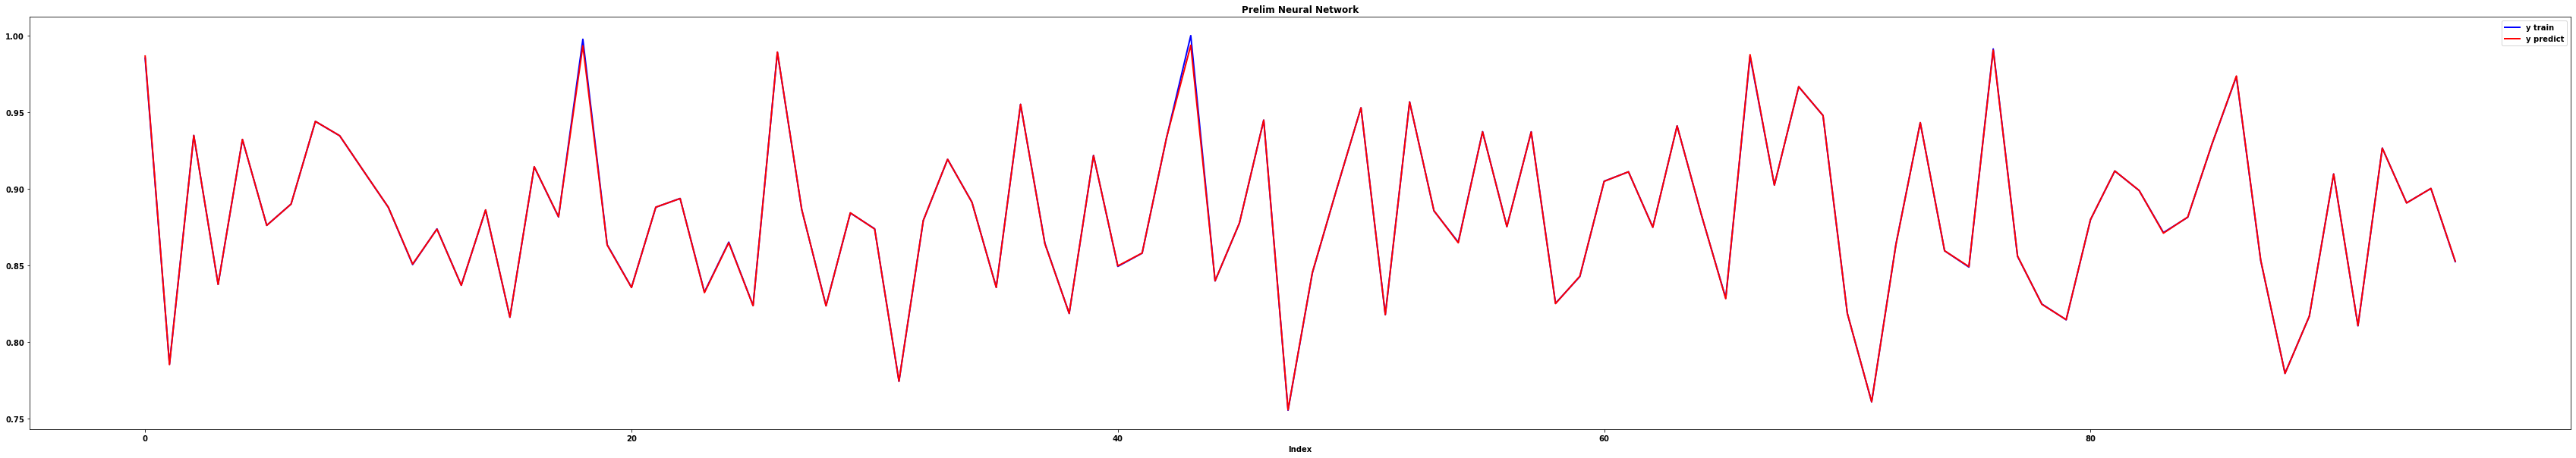

In [34]:
plt.plot( Y_train_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_predDE, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [35]:
y_testDE = []
for i in range(len(Y_hat_testDE)):
    #print(loss_traj[i])
    a = Y_hat_testDE[i].detach()
    y_testDE.append(a)

C:\Python\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Python\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


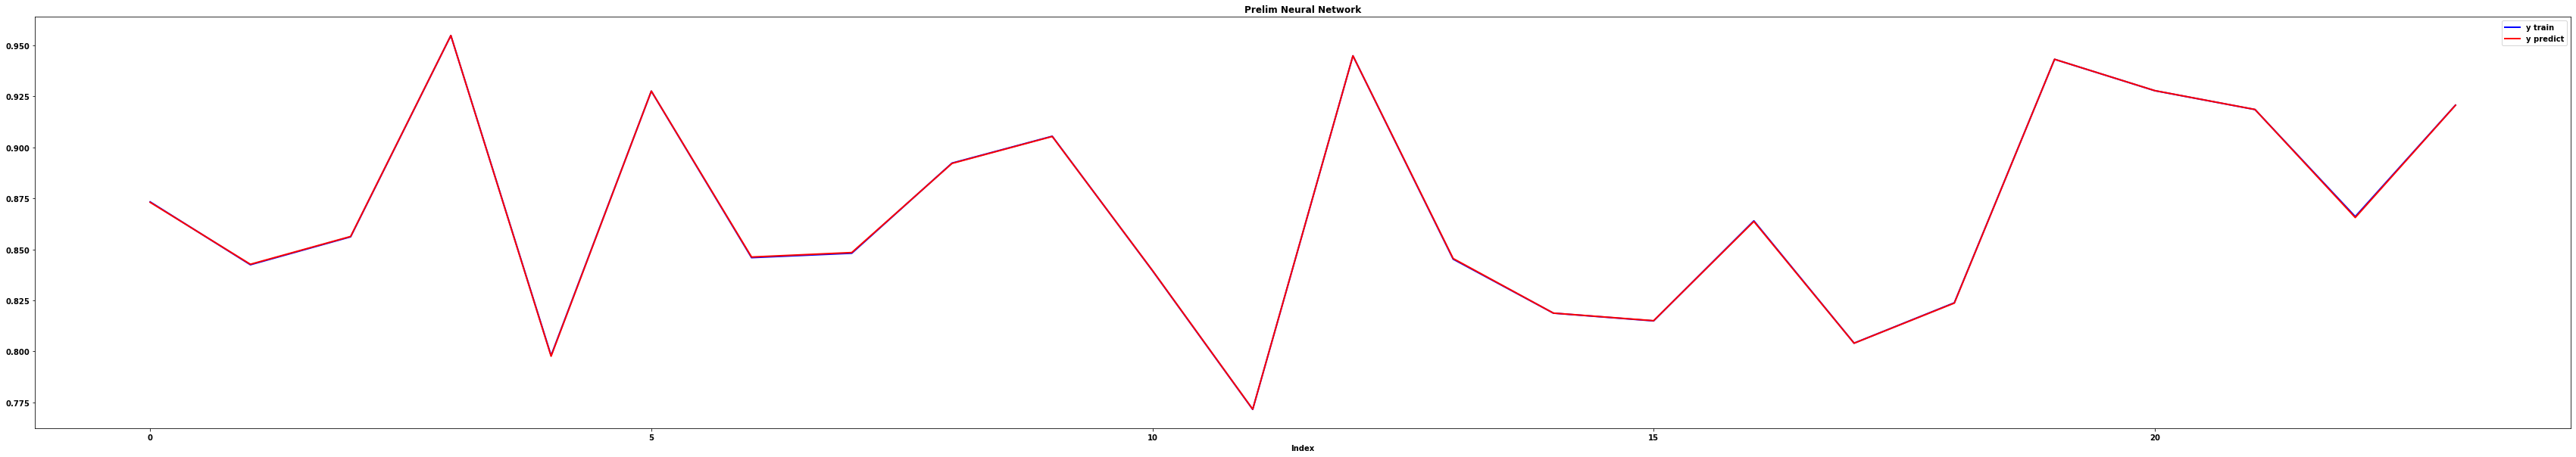

In [36]:
plt.plot( Y_test_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_testDE, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

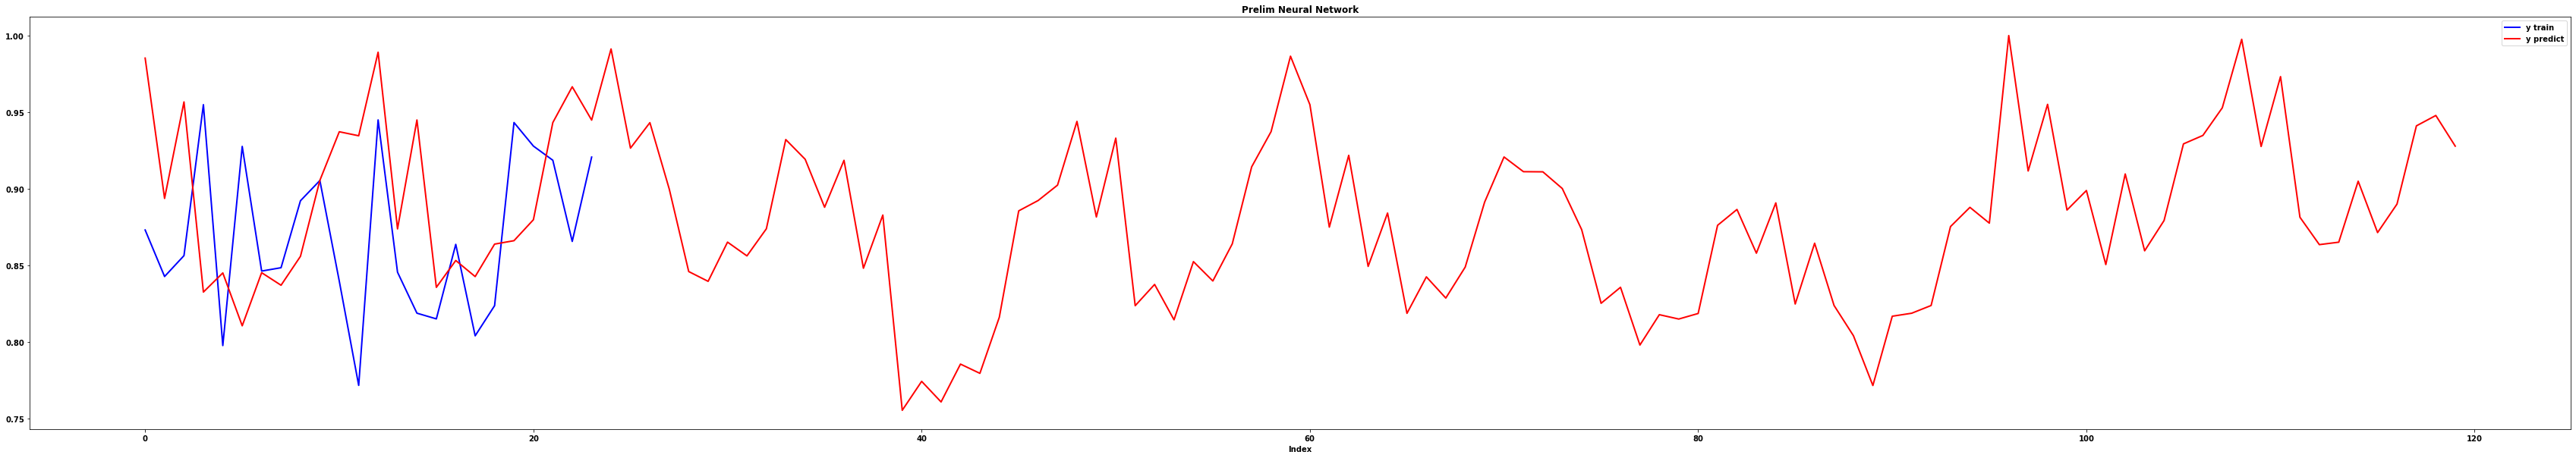

In [37]:
plt.plot(y_testDE, lw=2, color="blue", label="y train")
plt.plot( nonan['DE'].values, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [41]:
#Y_hat_train = nn.functional.log_softmax(y_testDE, dim=0)
#Y_train = nn.functional.log_softmax(nonan['DE'].values, dim=0)
#loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
#print(loss)

#print("Test error: ", (torch.linalg.norm(y_testDE-nonan['DE'].values[0:24],ord='fro')**2/len(x_testDE)).item())
print("Test error: ", ((y_testDE-nonan['DE'].values[0:24])**2/len(x_testDE)).item())

C:\Python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  import sys
C:\Python\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


ValueError: can only convert an array of size 1 to a Python scalar

In [46]:
#mse = (np.square(y_testDE - nonan['DE'].values[0:24])).mean(axis=None)
#mse = ((y_testDE - nonan['DE'].values[0:24])**2).mean(axis=None)
#.sub(input, other, 
#mse = ((torch.sub(y_testDE[0], nonan['DE'].values[0:24]))**2).mean(axis=None)


TypeError: sub(): argument 'other' (position 2) must be Tensor, not numpy.ndarray

In [15]:

# AT
country_datasets = []
datasets = []
country_list = ['BA', 'AT']

#for country in country_list:
#    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
#    country_datasets.append([country, country_dataset])
#    print(country)

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    #country_datasets.concat([country_datasets,country_dataset])
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])
    #b = pd.concat([country_datasets, country_dataset])
    #se = pd.Series(country_dataset.all())
    #b = country_datasets.concat([country_dataset,se])
    #country_datasets['new_col'] = country_dataset
    #print(country)

#print(b)
#print(country_datasets[1])

i = 0
for each in country_datasets:
    #print(each)
    #print("each")
    name = each[0]
    #print(name)
#    a = each[1]
    #dataset.append(a)
    dataset = each[1]

nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works

x_trainAT, x_testAT, y_trainAT, y_testAT = train_test_split(nonan.iloc[:, :1].values, nonan['AT'].values,test_size=0.795)

X_train_torchAT = torch.tensor(x_trainAT).float()
Y_train_torchAT = torch.tensor(y_trainAT).float()
X_test_torchAT = torch.tensor(x_testAT).float()
Y_test_torchAT = torch.tensor(y_testAT).float()

In [16]:
Y_hat_testAT = net(X_test_torchAT)

In [17]:
Y_hat_train = nn.functional.log_softmax(Y_hat_testAT, dim=0)
Y_train = nn.functional.log_softmax(Y_train_torchAT, dim=0)
loss = nn.KLDivLoss(log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(0.0581, grad_fn=<KlDivBackward0>)


C:\Python\lib\site-packages\torch\nn\functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


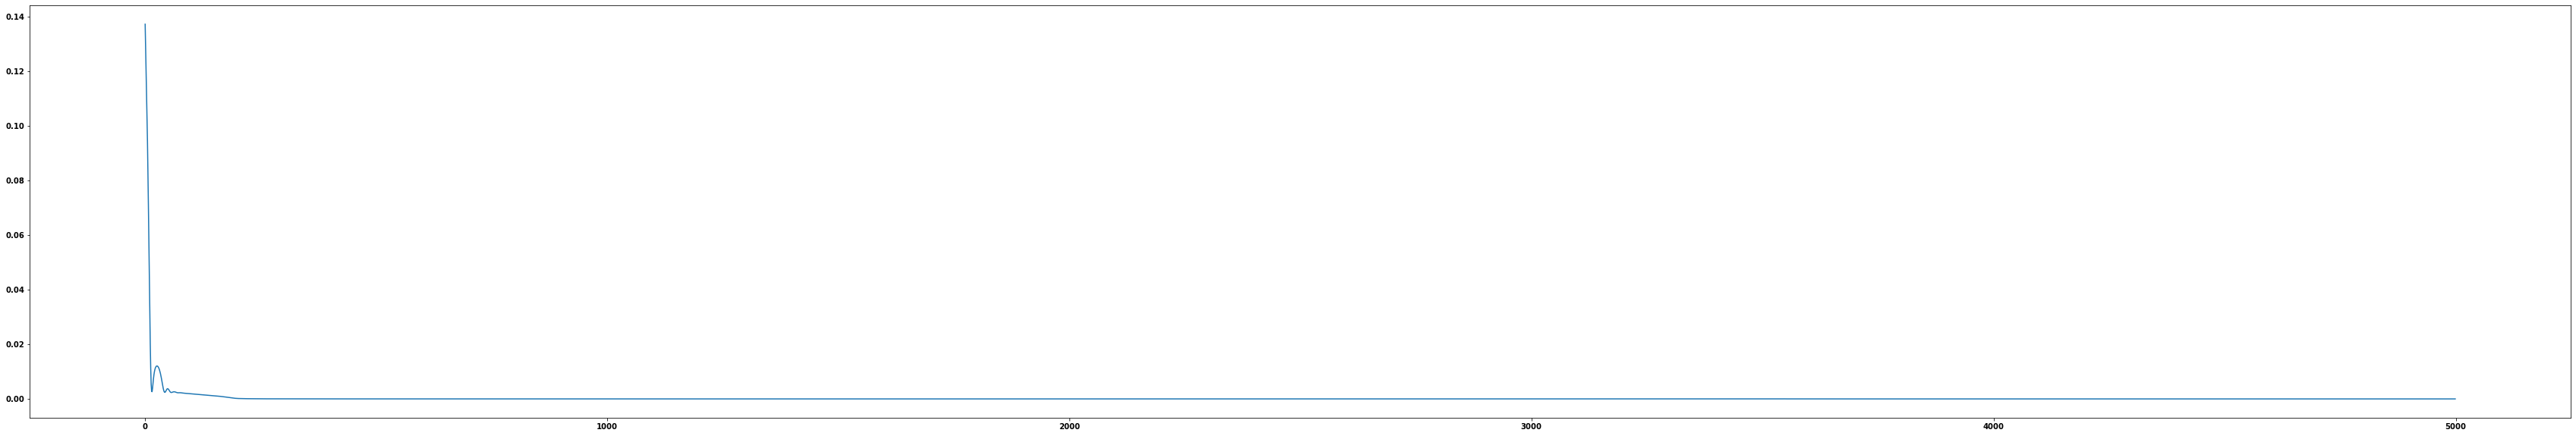

In [18]:
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)

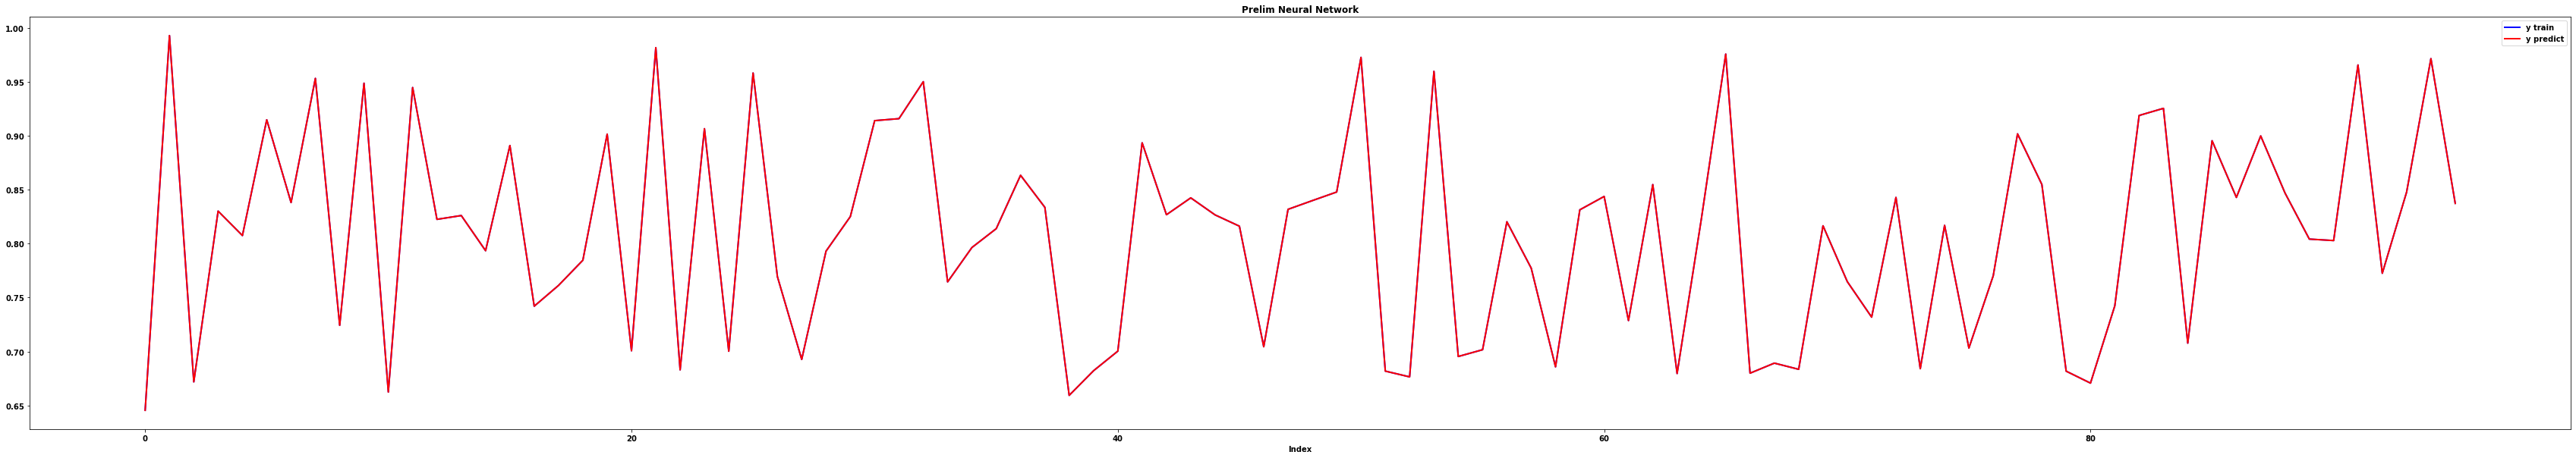

In [19]:
plt.plot( Y_test_torchAT, lw=2, color="blue", label="y train")
plt.plot( y_testAT, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

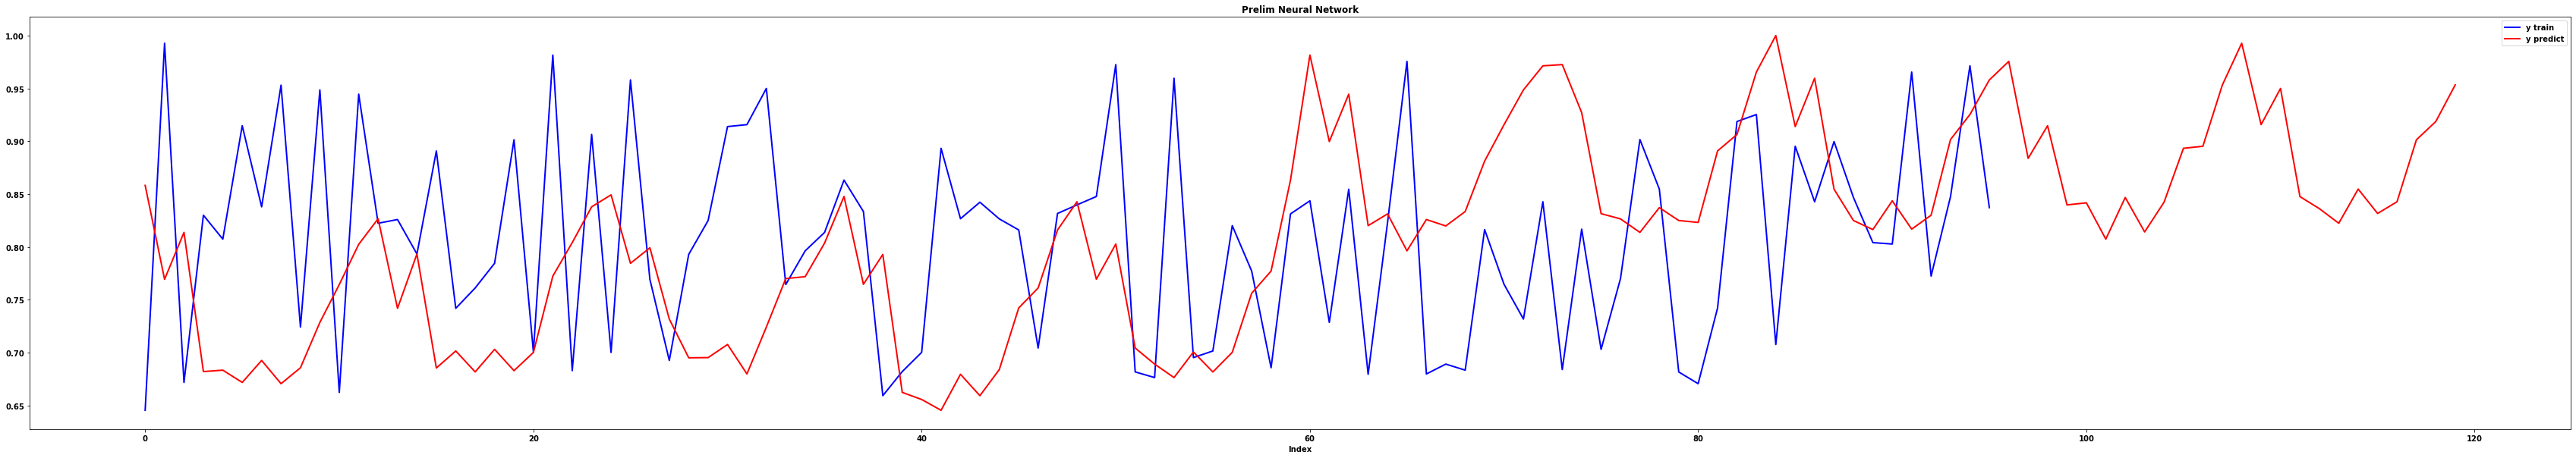

In [20]:
plt.plot(y_testAT, lw=2, color="blue", label="y train")
plt.plot( nonan['AT'].values, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [21]:
#TEST

[[[[],                          BA  BA_GDP     BA_POP  BA_TMP
DateTime                                              
2006-01-01 00:00:00  1425.0   12.86  3765424.0    -1.4
2006-01-01 01:00:00  1358.0   12.86  3765424.0    -1.4
2006-01-01 02:00:00  1283.0   12.86  3765424.0    -1.4
2006-01-01 03:00:00  1175.0   12.86  3765424.0    -1.4
2006-01-01 04:00:00  1134.0   12.86  3765424.0    -1.4
...                     ...     ...        ...     ...
2015-12-31 19:00:00  1959.0   16.21  3429361.0     3.4
2015-12-31 20:00:00  1810.0   16.21  3429361.0     3.4
2015-12-31 21:00:00  1680.0   16.21  3429361.0     3.4
2015-12-31 22:00:00  1606.0   16.21  3429361.0     3.4
2015-12-31 23:00:00  1537.0   16.21  3429361.0     3.4

[87648 rows x 4 columns]]],                           PL  PL_GDP      PL_POP  PL_TMP
DateTime                                                
2006-01-01 00:00:00  14268.0  344.62  38354450.0    -7.0
2006-01-01 01:00:00  13602.0  344.62  38354450.0    -7.0
2006-01-01 02:00:00  

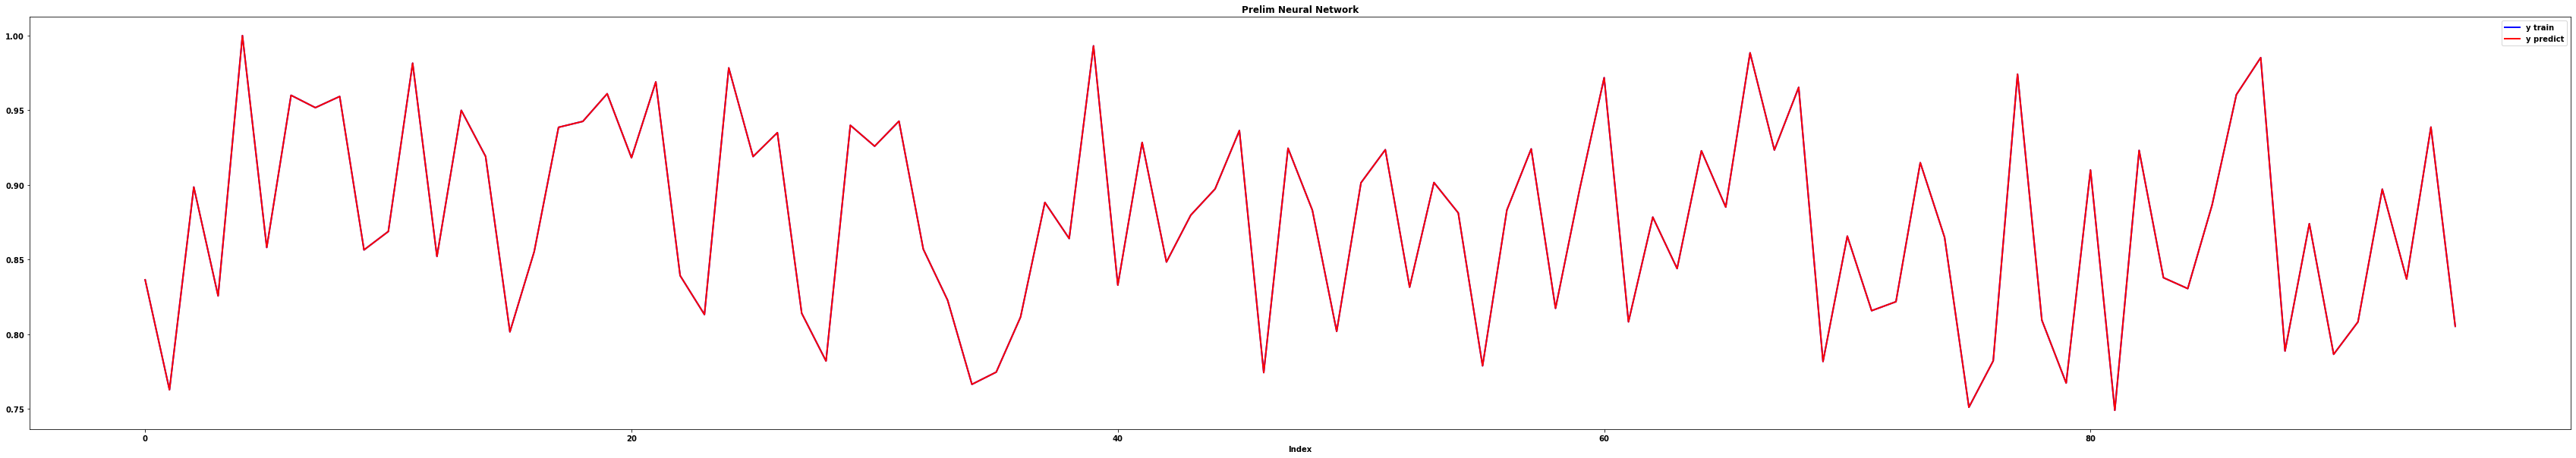

In [22]:
# PL


country_datasets = []
datasets = []
country_list = ['BA', 'PL']

#for country in country_list:
#    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
#    country_datasets.append([country, country_dataset])
#    print(country)

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    #country_datasets.concat([country_datasets,country_dataset])
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])
    #b = pd.concat([country_datasets, country_dataset])
    #se = pd.Series(country_dataset.all())
    #b = country_datasets.concat([country_dataset,se])
    #country_datasets['new_col'] = country_dataset
    #print(country)

#print(b)
print(country_datasets[1])

i = 0
for each in country_datasets:
    #print(each)
    #print("each")
    name = each[0]
    #print(name)
#    a = each[1]
    #dataset.append(a)
    dataset = each[1]

nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works


x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, :1].values, nonan['PL'].values,test_size=0.795)

X_train_torchPL = torch.tensor(x_train).float()
Y_train_torchPL = torch.tensor(y_train).float()
X_test_torchPL = torch.tensor(x_test).float()
Y_test_torchPL = torch.tensor(y_test).float()

Y_hat_testPL = net(X_test_torchPL)
#print("Test error: ", (torch.linalg.norm(Y_hat_testPL-Y_test_torchPL,ord='fro')**2/len(x_test)).item())
y_testPL = []
for i in range(len(Y_test_torchPL)):
    #print(loss_traj[i])
    a = Y_test_torchPL[i].detach()
    y_testPL.append(a)
    
plt.plot( Y_test_torchPL, lw=2, color="blue", label="y train")
plt.plot( y_testPL, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [23]:
Y_hat_train = nn.functional.log_softmax(Y_hat_testPL, dim=0)
Y_train = nn.functional.log_softmax(Y_test_torchPL, dim=0)
loss = nn.KLDivLoss(log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(4.5799e-05, grad_fn=<KlDivBackward0>)


C:\Python\lib\site-packages\torch\nn\functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


[[[[],                          BA  BA_GDP     BA_POP  BA_TMP
DateTime                                              
2006-01-01 00:00:00  1425.0   12.86  3765424.0    -1.4
2006-01-01 01:00:00  1358.0   12.86  3765424.0    -1.4
2006-01-01 02:00:00  1283.0   12.86  3765424.0    -1.4
2006-01-01 03:00:00  1175.0   12.86  3765424.0    -1.4
2006-01-01 04:00:00  1134.0   12.86  3765424.0    -1.4
...                     ...     ...        ...     ...
2015-12-31 19:00:00  1959.0   16.21  3429361.0     3.4
2015-12-31 20:00:00  1810.0   16.21  3429361.0     3.4
2015-12-31 21:00:00  1680.0   16.21  3429361.0     3.4
2015-12-31 22:00:00  1606.0   16.21  3429361.0     3.4
2015-12-31 23:00:00  1537.0   16.21  3429361.0     3.4

[87648 rows x 4 columns]]],                          LT  LT_GDP     LT_POP  LT_TMP
DateTime                                              
2006-01-01 00:00:00     NaN    8.74  3303335.0    -7.0
2006-01-01 01:00:00     NaN    8.74  3303335.0    -7.0
2006-01-01 02:00:00     NaN  

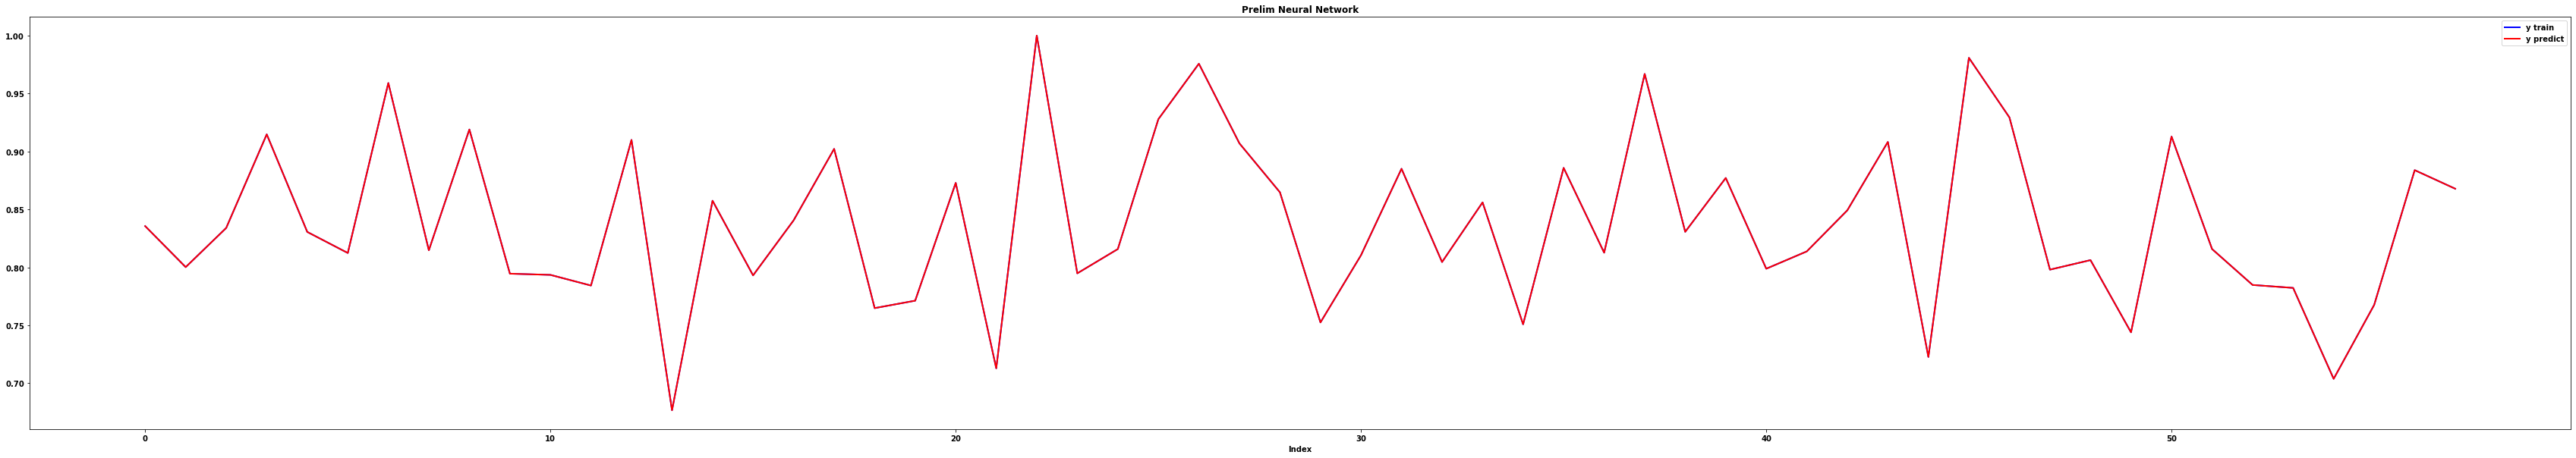

In [24]:
# ME


country_datasets = []
datasets = []
country_list = ['BA', 'LT']

#for country in country_list:
#    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
#    country_datasets.append([country, country_dataset])
#    print(country)

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    #country_datasets.concat([country_datasets,country_dataset])
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])
    #b = pd.concat([country_datasets, country_dataset])
    #se = pd.Series(country_dataset.all())
    #b = country_datasets.concat([country_dataset,se])
    #country_datasets['new_col'] = country_dataset
    #print(country)

#print(b)
#print(country_datasets[1])

i = 0
for each in country_datasets:
    #print(each)
    #print("each")
    name = each[0]
    #print(name)
#    a = each[1]
    #dataset.append(a)
    dataset = each[1]

nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works


x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, :1].values, nonan['LT'].values,test_size=0.795)

X_train_torchLT = torch.tensor(x_train).float()
Y_train_torchLT = torch.tensor(y_train).float()
X_test_torchLT = torch.tensor(x_test).float()
Y_test_torchLT = torch.tensor(y_test).float()

Y_hat_testLT = net(X_test_torchLT)
#print("Test error: ", (torch.linalg.norm(Y_hat_testPL-Y_test_torchPL,ord='fro')**2/len(x_test)).item())
y_testLT = []
for i in range(len(Y_test_torchLT)):
    #print(loss_traj[i])
    a = Y_test_torchLT[i].detach()
    y_testLT.append(a)
    
plt.plot( Y_test_torchLT, lw=2, color="blue", label="y train")
plt.plot( y_testLT, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [25]:
Y_hat_train = nn.functional.log_softmax(Y_hat_testLT, dim=0)
Y_train = nn.functional.log_softmax(Y_test_torchLT, dim=0)
loss = nn.KLDivLoss(log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(9.0307e-05, grad_fn=<KlDivBackward0>)


C:\Python\lib\site-packages\torch\nn\functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


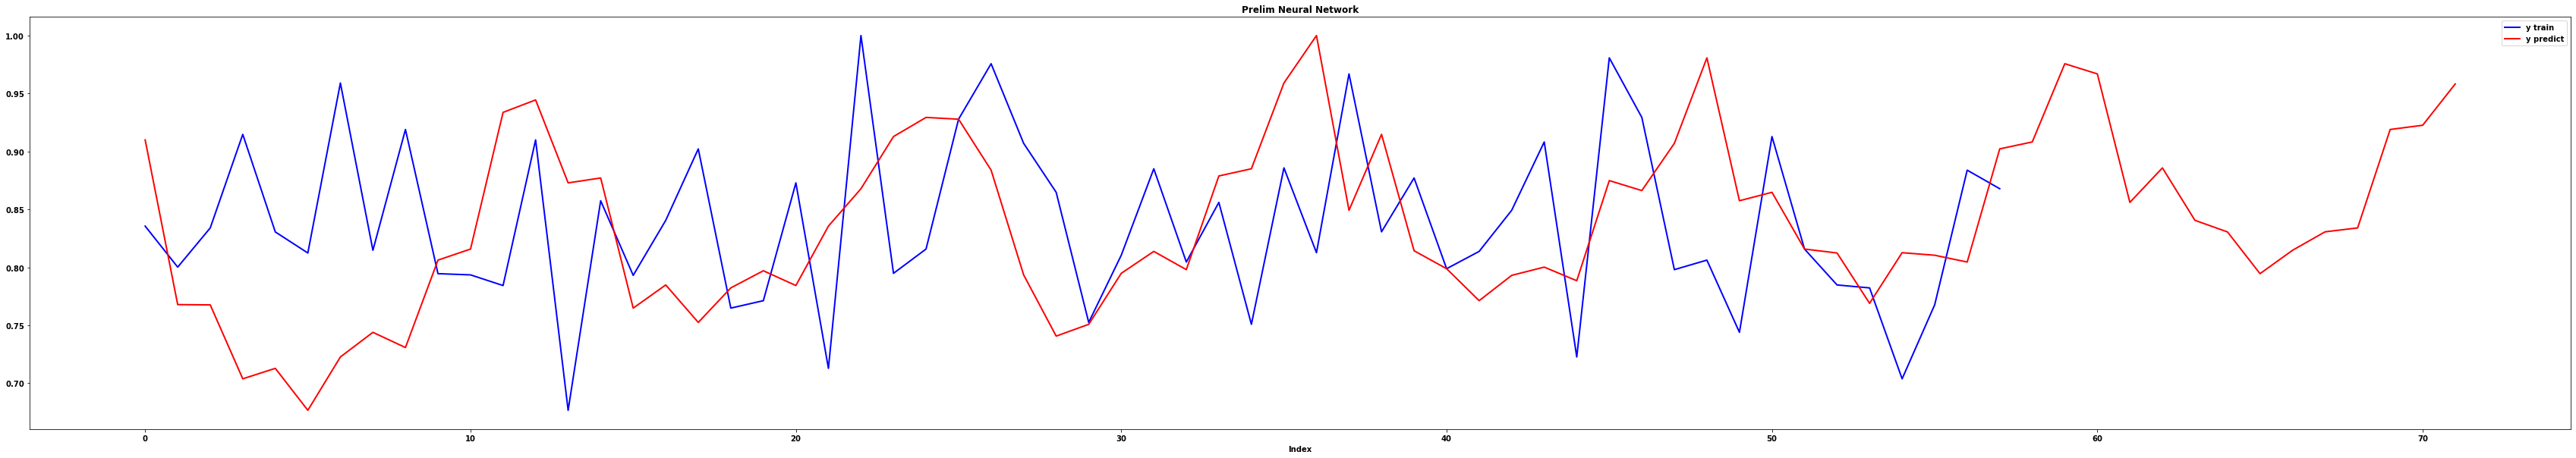

In [26]:
#plt.plot(nonan.iloc[:, :1].values, lw=2, color="blue", label="y train")
#y_testLT 
plt.plot(y_testLT, lw=2, color="blue", label="y train")
plt.plot( nonan['LT'].values, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()